# RandomForest回归分析

## $\S1$ Configuration & Data Preparation

In [14]:
# Configuration
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## Data Path
Path = "./Raw_Data_5.xlsx"
Dependent_Variable = "USD_index_Close"

## Param Grid
param_grid = {
    "model__n_estimators": [200, 500, 800],
    "model__max_depth": [5, 10, None],              # None表示无限制
    "model__min_samples_split": [2, 5, 10],         # 内部分枝的最小样本数
    "model__min_samples_leaf": [1, 2, 4],         # 叶子节点的最小样本数
    "model__max_features": ["sqrt", 0.3, 0.5]       # 划分考虑的特征数
}

## CV Scoring
scoring = {
    ### sklearn默认maximize the score, so we use prefix "neg"
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}


In [15]:
# Data Preparation
## Loading Data
Data = pd.read_excel(Path, index_col="日期")
print("Data Size:", Data.shape)

## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
# X,y = X.values, y.values

Data Size: (3209, 36)


In [16]:
### Split Train, Valid and Test Sets
train_size = int(len(Data) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

#### Split Train Set into Tims Series
tsCV = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tsCV.split(X_train)):
    print(f"Fold {fold}: Train {len(train_idx)}, Test {len(test_idx)}")


Fold 0: Train 432, Test 427
Fold 1: Train 859, Test 427
Fold 2: Train 1286, Test 427
Fold 3: Train 1713, Test 427
Fold 4: Train 2140, Test 427


## $\S2$ Model Training & Predicting

In [17]:
## Generating Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
    )),
]
)

## Model Selection
### Grid_Search with Pipe on Grid using TimeSeriesSplit CV on Train Set
gsCV = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv = tsCV,
    scoring = scoring,
    refit = "R2",
    n_jobs = -1,
    verbose = 2
)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


d:\Python_Venvs\Venv3.11\Finance_Data\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [5, 10, ...], 'model__max_features': ['sqrt', 0.3, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [18]:
### printing best model
#### Best Hyper Parameters:
print("Grid Search 最佳参数: ", gsCV.best_params_)
print("对应的(CV平均)最优R2:", gsCV.best_score_)

#### CV Results:
result = pd.DataFrame(gsCV.cv_results_)
cols_to_show = ["mean_test_RMSE", "mean_test_MAE", "mean_test_R2"]
result["mean_test_MAE"] = -result["mean_test_MAE"]
result["mean_test_RMSE"] = -result["mean_test_RMSE"]
print(result[cols_to_show].sort_values(by="mean_test_R2", ascending=False).head(10))

Grid Search 最佳参数:  {'model__max_depth': 5, 'model__max_features': 0.3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
对应的(CV平均)最优R2: 0.010216359914977912
    mean_test_RMSE  mean_test_MAE  mean_test_R2
39        0.005065       0.003859      0.010216
36        0.005069       0.003865      0.008591
25        0.005077       0.003859      0.007984
27        0.005071       0.003860      0.007819
24        0.005079       0.003858      0.007520
10        0.005083       0.003869      0.006468
28        0.005076       0.003871      0.006415
22        0.005082       0.003861      0.006348
19        0.005082       0.003861      0.006348
40        0.005078       0.003871      0.006222


In [19]:
## Model Prediction
### 在gsCV中，refit已经选取了最优模型，Pipe在整个训练集上进行了重新训练
best_rf = gsCV.best_estimator_
y_pred = best_rf.predict(X_test)

Text(0.5, 1.0, 'Random Forest Regression Prediction')

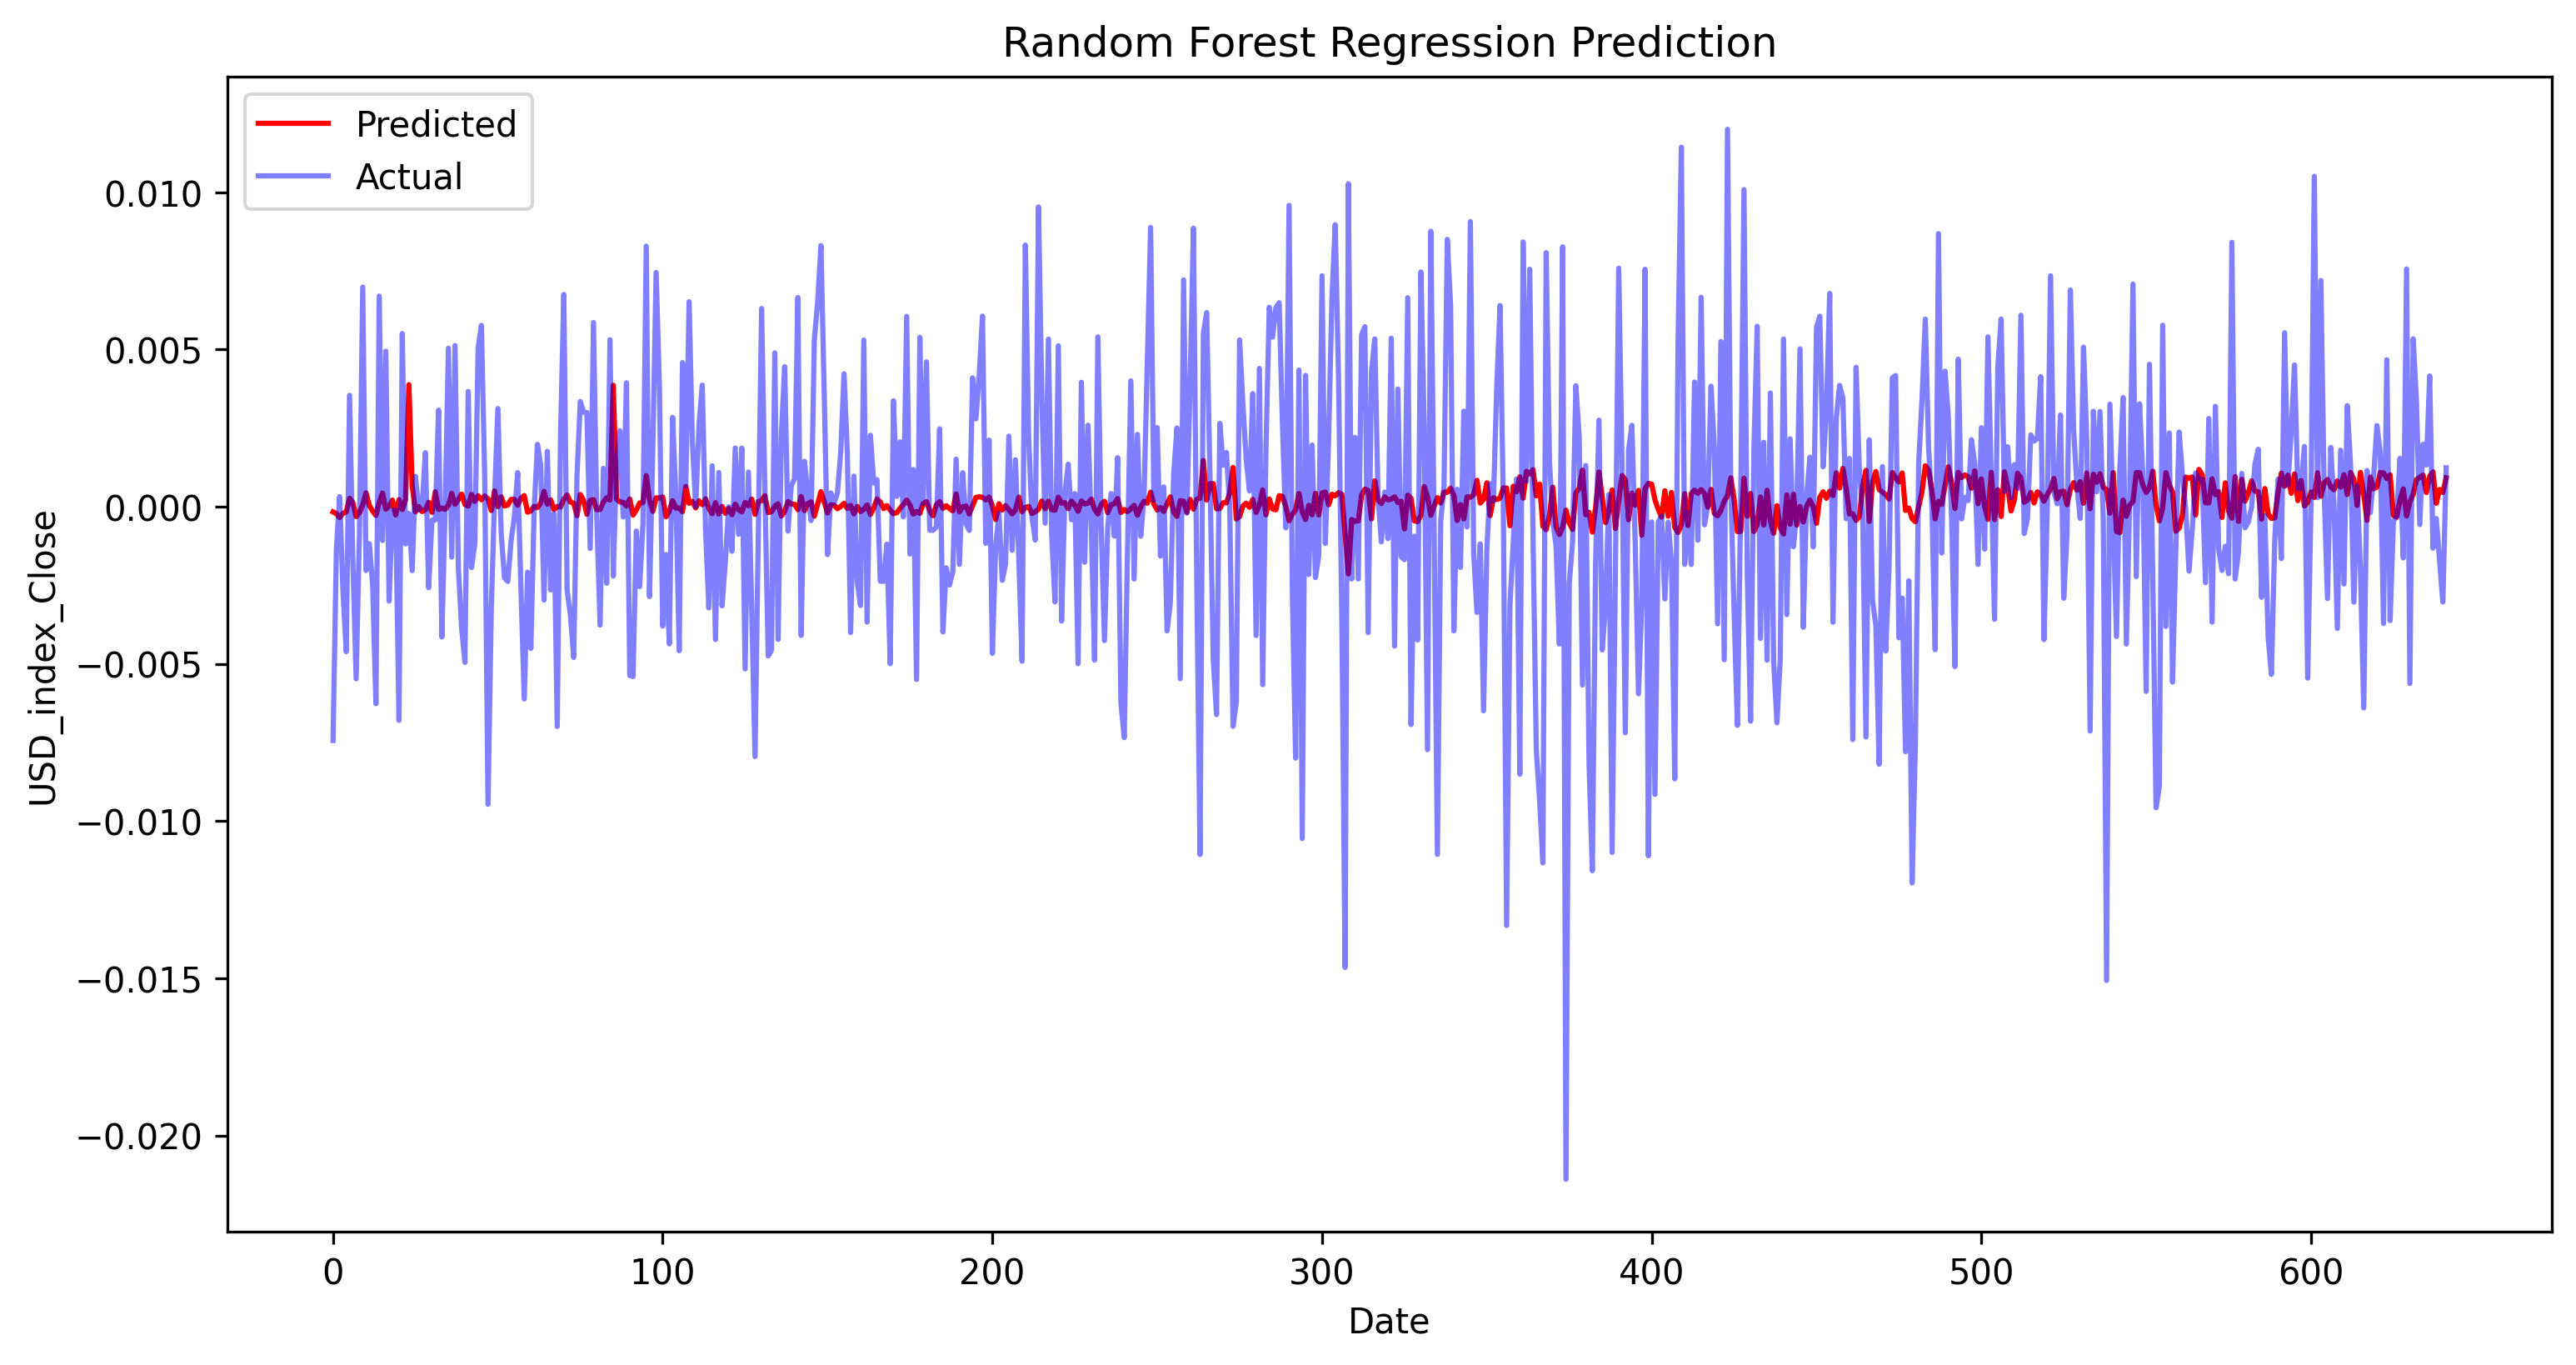

In [20]:
### Prediction Visualization
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test.values, label="Actual", color="blue", alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD_index_Close")
ax1.legend()
ax1.set_title("Random Forest Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [21]:
## Model Evaluation
# 4.2 计算测试集指标
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
## Campbell–Thompson OOS-R²:
oor2 = np.sum((y_test.values - y_pred)**2) / np.sum((y_test.values - np.mean(y_train))**2) 

print("=== 测试集表现 ===")
print(f"MAE  : {test_mae:.6f}")
print(f"RMSE  : {test_rmse:.6f}")
print(f"R^2  : {test_r2:.6f}")
print(f"Out of Sample R^2  : {test_r2:.6f}")

=== 测试集表现 ===
MAE  : 0.003274
RMSE  : 0.004304
R^2  : -0.002917
Out of Sample R^2  : -0.002917


In [22]:
## Model Explanation
importances = best_rf.named_steps["model"].feature_importances_
### Feature Importance
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(feature_importance.head(20))

USD_index_Close_Std3     0.139470
VIX_Delta                0.099750
USD_JPY_Open             0.095591
USD_index_Close_Std7     0.057213
GER_index_Open           0.055597
US_index_Open            0.046024
US_10Y-GER_10Y_Open      0.041486
GOLD_Open                0.040171
JP_index_Open            0.028720
USD_EUR_Open             0.028626
USD_index_Close_Std14    0.028137
GER_10Y-UK_10Y_Open      0.027306
CN_index_Open            0.025470
USD_index_Close_Lag1     0.025432
WTI_Open                 0.024025
VIX_Open                 0.022874
UK_index_Open            0.022776
CN_10Y-GER_10Y_Open      0.019168
USD_GBP_Open             0.016583
US_10Y-UK_10Y_Open       0.015827
dtype: float64
